In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties as unc
plt.style.use('belle2')
#%jsroot on

#%run functins.ipynb

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
file_bkg="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0mumupip4Streams.root"
#file_signal="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0mumupip200000.root"



file_jpsi="/pnfs/desy.de/belle/local/user/msobotzi/jpsi/afterAcceptance/B0mumupip.root"


In [3]:
class trimVars():
    def trimCosTheta_L(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('abs(cosTheta_L) < 0.75')
            if q2 == 4:
                df = df.query('abs(cosTheta_L) < 0.95')
        
        if int(Btree) == 521:
            if pi == 'pip':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 ==4:
                    df = df.query('abs(cosTheta_L) < 0.95')
            if pi =='pi0':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 !=4:
                    df = df.query('abs(cosTheta_L) < 0.9')
        return df

    
    def trimCosTheta_K(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('cosTheta_K > -0.9')
            elif q2 != 4:
                df = df.query('cosTheta_K > -0.9')
            else:
                df = df.query('abs(cosTheta_K) < 0.95')
                
        if int(Btree) == 521:
            if q2 == 1:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                else:
                    df = df.query('cosTheta_K > 0.9')
            elif q2 != 4:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                elif pi == 'pi0':
                    df = df.query('cosTheta_K > -0.9')
                    
            elif q2 == 4:
                if pi == 'pip':
                    df = df.query('abs(cosTheta_K) > -0.95')
                if pi == 'pi0':
                    df = df.query('abs(cosTheta_K) < 0.9')
        return df
    
    def trimmers(df, Btree, pi, ll, q2):
        df = trimVars.trimCosTheta_L(df, Btree, pi, ll, q2)
        df = trimVars.trimCosTheta_K(df, Btree, pi, ll, q2)
        return df



In [4]:
def process_MC_data_combined_jpsi(file_path_background, Btree, pi, ll, q2):
    def process_mc_data(file_path, q2):
        df = uproot.open(f"{file_path}:rec511")
        keylist = df.keys()
        df = df.arrays(library='pd')
        mc_data = trimVars.trimmers(df, Btree, pi, ll, q2)
        mc_cut = mc_data.query('NNPass==1')
        mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
        return mc_cut_best_candidate
    
    
    mc_cut_best_candidate_background = process_mc_data(file_path_background, q2)
   
    # Apply range cut for deltaE
    deltaE_range = (-0.15, 0.15)

    # Signal
    mc_signal_q2cut_jpsi_kst_wot_filter = mc_cut_best_candidate_background
    mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter[(mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] >= deltaE_range[0]) & (mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] <= deltaE_range[1])]
    mc_only_signal_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst.query('isSignal==1')
    mc_scf_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst.query('isSignal!=1')

    # Weight
    mc_signal_weight_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
    mc_only_signal_weight_q2cut_jpsi_kst = mc_only_signal_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
    mc_scf_weight_q2cut_jpsi_kst=mc_scf_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
    
    # Data
    mc_signal_data =mc_signal_q2cut_jpsi_kst
    mc_only_signal_data = mc_only_signal_q2cut_jpsi_kst
    mc_scf_data = mc_scf_q2cut_jpsi_kst
    

    # Weight Data
    mc_signal_weight = mc_signal_weight_q2cut_jpsi_kst
    mc_only_signal_weight = mc_only_signal_weight_q2cut_jpsi_kst
    mc_scf_weight = mc_scf_weight_q2cut_jpsi_kst
    
    return mc_signal_data,mc_only_signal_data,mc_scf_data,mc_signal_weight,mc_only_signal_weight,mc_scf_weight


In [5]:
def process_MC_data_combined_jpsi_wo_klcut(file_path_jpsi,loose_cut,particle_type):
    def process_mc_data(file_path,loose_cut):
        mc_data = uproot.open(f"{file_path}:rec511")
        keylist = mc_data.keys()
        mc = mc_data.arrays(keylist, library='pd')

        if loose_cut == True:
            Btree = 511
            mc_cut =  mc.query(f'q2_regcomb_pred{Btree} > 0.05')
        elif loose_cut == False:
            mc_cut = mc.query('NNPass==1')
        else:
            raise ValueError(f"Unknown mc_bkg_cut: {mc_bkg_cut}")

        mc_cut_best_candidate = mc_cut.query('bestCandidate == 1')
        return mc_cut_best_candidate
    
    
    mc_cut_best_candidate_background = process_mc_data(file_path_jpsi,loose_cut=False)
   
    # Apply range cut for deltaE
    deltaE_range = (-0.15, 0.15)

    # Signal
    mc_signal_q2cut_jpsi_kst_wot_filter = mc_cut_best_candidate_background
    mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter[(mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] >= deltaE_range[0]) & (mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] <= deltaE_range[1])]
    mc_only_signal_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst.query('isSignal==1')
    mc_scf_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst.query('isSignal!=1')

    # Weight
    mc_signal_weight_q2cut_jpsi_kst=mc_signal_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
    mc_only_signal_weight_q2cut_jpsi_kst = mc_only_signal_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
    mc_scf_weight_q2cut_jpsi_kst=mc_scf_q2cut_jpsi_kst["PIDCorrectionAndAcceptanceWeight"]
    
    # Data
    mc_signal_data =mc_signal_q2cut_jpsi_kst
    mc_only_signal_data = mc_only_signal_q2cut_jpsi_kst
    mc_scf_data = mc_scf_q2cut_jpsi_kst
    

    # Weight Data
    mc_signal_weight = mc_signal_weight_q2cut_jpsi_kst
    mc_only_signal_weight = mc_only_signal_weight_q2cut_jpsi_kst
    mc_scf_weight = mc_scf_weight_q2cut_jpsi_kst
    
    return mc_signal_data,mc_only_signal_data,mc_scf_data,mc_signal_weight,mc_only_signal_weight,mc_scf_weight


In [6]:
q2reg_value = 11

mc_mu_signal_wo_klcut,mc_mu_only_signal_wo_klcut,mc_mu_scf_wo_klcut, mc_signal_weight_wo_klcut, mc_mu_only_signal_weight_wo_klcut,mc_mu_scf_weight_wo_klcut = process_MC_data_combined_jpsi_wo_klcut(file_jpsi,False, "mu")

mc_mu_signal,mc_mu_only_signal,mc_mu_scf, mc_signal_weight, mc_mu_only_signal_weight,mc_mu_scf_weight = process_MC_data_combined_jpsi(file_jpsi,'511','pip','mumu','11')


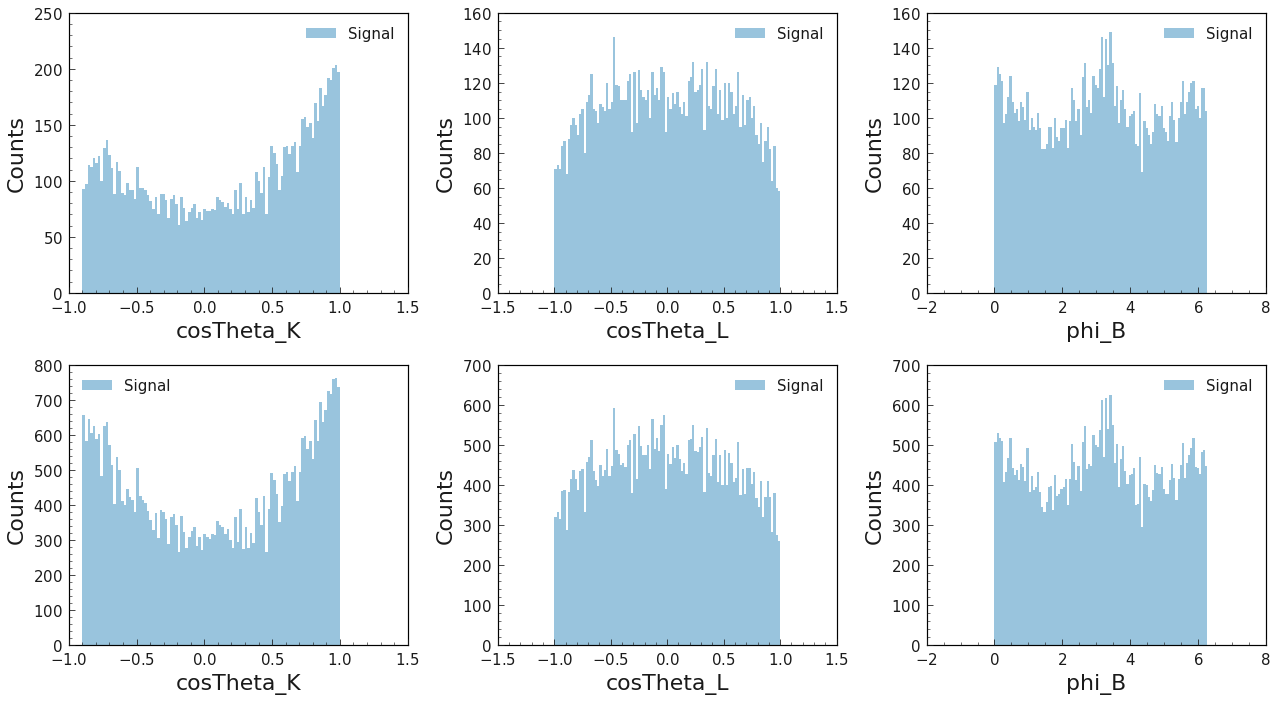

In [7]:
def plot_histogram(ax, bins, data_dict, labels, xlabel, ylabel, weights=None):
    if weights is None:
        ax.hist(data_dict, bins=bins, alpha=0.5, label=labels)
    else:
        ax.hist(data_dict, bins=bins, weights=weights, alpha=0.5, label=labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

plot_histogram(axs[0, 0], 100, mc_mu_only_signal["cosTheta_K"], "Signal", 'cosTheta_K', 'Counts')

plot_histogram(axs[0, 1], 100, mc_mu_only_signal["cosTheta_L"], "Signal", 'cosTheta_L', 'Counts')

plot_histogram(axs[0, 2], 100, mc_mu_only_signal["phi_B"], "Signal", 'phi_B', 'Counts')

plot_histogram(axs[1, 0], 100, mc_mu_only_signal["cosTheta_K"], ["Signal"], 'cosTheta_K', 'Counts', weights=mc_mu_only_signal_weight)

plot_histogram(axs[1, 1], 100, mc_mu_only_signal["cosTheta_L"], ["Signal"], 'cosTheta_L', 'Counts', weights=mc_mu_only_signal_weight)

plot_histogram(axs[1, 2], 100, mc_mu_only_signal["phi_B"], ["Signal"], 'phi_B', 'Counts', weights=mc_mu_only_signal_weight)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


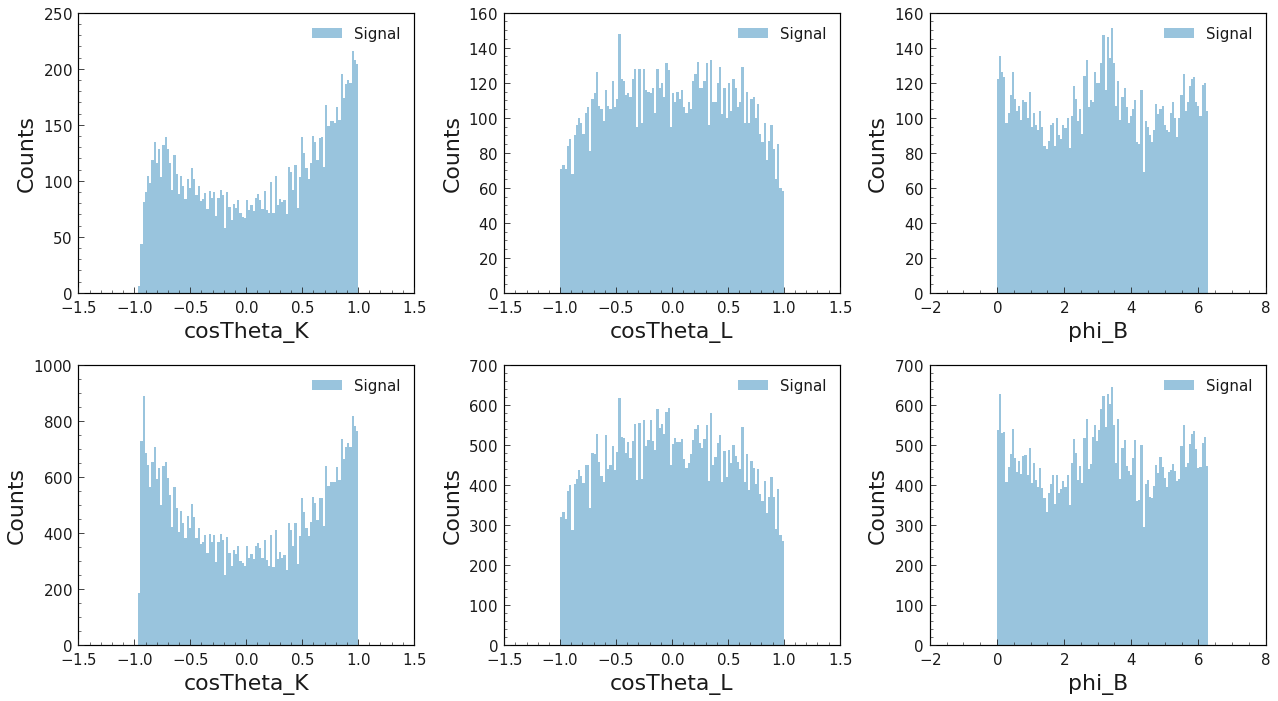

In [8]:
def plot_histogram(ax, bins, data_dict, labels, xlabel, ylabel, weights=None):
    if weights is None:
        ax.hist(data_dict, bins=bins, alpha=0.5, label=labels)
    else:
        ax.hist(data_dict, bins=bins, weights=weights, alpha=0.5, label=labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

plot_histogram(axs[0, 0], 100, mc_mu_only_signal_wo_klcut["cosTheta_K"], "Signal", 'cosTheta_K', 'Counts')

plot_histogram(axs[0, 1], 100, mc_mu_only_signal_wo_klcut["cosTheta_L"], "Signal", 'cosTheta_L', 'Counts')

plot_histogram(axs[0, 2], 100, mc_mu_only_signal_wo_klcut["phi_B"], "Signal", 'phi_B', 'Counts')

plot_histogram(axs[1, 0], 100, mc_mu_only_signal_wo_klcut["cosTheta_K"], ["Signal"], 'cosTheta_K', 'Counts', weights=mc_mu_only_signal_weight_wo_klcut)

plot_histogram(axs[1, 1], 100, mc_mu_only_signal_wo_klcut["cosTheta_L"], ["Signal"], 'cosTheta_L', 'Counts', weights=mc_mu_only_signal_weight_wo_klcut)

plot_histogram(axs[1, 2], 100, mc_mu_only_signal_wo_klcut["phi_B"], ["Signal"], 'phi_B', 'Counts', weights=mc_mu_only_signal_weight_wo_klcut)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [9]:
import zfit
import tensorflow as tf
import pandas as pd
import numpy as np

class p5_prime_pdf(zfit.pdf.ZPDF):
    _N_OBS = 3  # dimension, can be omitted
    _PARAMS = ['param_fl','param_s3','param_p5']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x, y, z  = x.unstack_x()  # x=costk, y=costl, z=phib
        param_fl = self.params['param_fl']
        param_s3 = self.params['param_s3']
        param_p5 = self.params['param_p5']
        
        return (9/(8*np.pi))*((3/4)*(1-param_fl)* (1-x**2) + param_fl * x**2 + \
               (1/4) *(1 - param_fl)* (1-x**2)* (2 * y**2 - 1)- \
               param_fl * x**2 * (2 * y**2 - 1) + param_s3 *(1-x**2)*(1-y**2) * tf.cos(2*z)+ \
               tf.sqrt(param_fl*(1-param_fl)) * param_p5 * 2*tf.sqrt(1-x**2) *x * tf.sqrt(1-y**2)* tf.cos(z))



def p5p_3D_fit(cost_k_data,cost_l_data, phi_b_data,param_fl_start,param_s3_start,param_p5_start,weight,floating=True):

    # create space
    obs_cost_k  = zfit.Space('cosTheta_K', limits=(min(cost_k_data),max(cost_k_data)))
    obs_cost_l  = zfit.Space('cosTheta_L', limits=(min(cost_l_data),max(cost_l_data)))
    obs_phi_b   = zfit.Space('phi_B', limits=(0, np.pi))

    obs = obs_cost_k * obs_cost_l * obs_phi_b

        # data
    df_sig         = pd.concat([cost_k_data,cost_l_data, phi_b_data],  axis=1)
    data_fit_sig   = zfit.Data.from_pandas(df_sig, obs = obs,weights=weight)

        #parameter variable
    r = np.round(np.random.rand(),decimals=8)

        #parameters
    param_fl  = zfit.Parameter(f'param_fl_{r}',  param_fl_start,  floating=floating)
    param_s3  = zfit.Parameter(f'param_s3_{r}',  param_s3_start,  floating=floating)
    param_p5  = zfit.Parameter(f'param_p5_{r}',  param_p5_start,  floating=floating)

    extended = zfit.Parameter(f"extended_{r}", 10000)

    pdf_3D = p5_prime_pdf(param_fl=param_fl, param_s3=param_s3, param_p5=param_p5, obs=obs, extended=extended)
    pdf_3D.update_integration_options(max_draws=10000, tol=1e-4)  # Adjust parameters as needed


        # create NLL
    nll       = zfit.loss.ExtendedUnbinnedNLL(model=pdf_3D, data=data_fit_sig)
    minimizer = zfit.minimize.Minuit()
    result    = minimizer.minimize(nll)

    if floating==True:
        result.hesse(name='hesse')
               
    print(result.params)
    print("Fit result valid:")
    print(result.valid)
    
    return pdf_3D

def fold_data(data):
    data['cosTheta_L'] = data['cosTheta_L'].abs()
    phi_b_gr = data.query(f"phi_B > {np.pi}")
    phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']
    phi_b_kl = data.query(f"phi_B <= {np.pi}")
    folded_data = pd.concat([phi_b_kl, phi_b_gr])
    return folded_data

mc_mu_only_signal_fold = fold_data(mc_mu_only_signal)
mc_mu_only_signal_wo_klcut_fold = fold_data(mc_mu_only_signal_wo_klcut)

mc_mu_only_signal_weight_fold=mc_mu_only_signal_fold["PIDCorrectionAndAcceptanceWeight"]

mc_mu_only_signal_weight_wo_klcut_fold=mc_mu_only_signal_wo_klcut_fold["PIDCorrectionAndAcceptanceWeight"]

# Example usage with adjusted starting parameters
param_fl_start = 0.5  # Adjust based on your data 0.5
param_s3_start = 0.01  # Adjust based on your data -0.01
param_p5_start = 0.02  # Adjust based on your data 0.02

# Fit with phi_B greater than np.pi
print("Fitting for phi_B greater than pi:")
pdf_fit_signal_gr = p5p_3D_fit(mc_mu_only_signal_fold["cosTheta_K"], mc_mu_only_signal_fold["cosTheta_L"], mc_mu_only_signal_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start, weight=mc_mu_only_signal_weight_fold,
                               floating=True)

# Fit with phi_B less than or equal to np.pi
print("Fitting for phi_B less than or equal to pi:")
pdf_fit_signal_kl = p5p_3D_fit(mc_mu_only_signal_wo_klcut_fold["cosTheta_K"], mc_mu_only_signal_wo_klcut_fold["cosTheta_L"], mc_mu_only_signal_wo_klcut_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start, weight=mc_mu_only_signal_weight_wo_klcut_fold,
                               floating=True)


# Calculate total signal events
mc_mu_only_signal_MC_data = sum(mc_mu_only_signal_weight_fold)
mc_mu_only_signal_MC_data_wo_klcut = sum(mc_mu_only_signal_weight_wo_klcut_fold)

# Now, let's print the total signal events again
print("Signal Events in MC Data =", mc_mu_only_signal_MC_data)
print("Signal Events in MC Data_wo_klcut =", mc_mu_only_signal_MC_data_wo_klcut)


<ipython-input-9-5d4acc57bd6a>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cosTheta_L'] = data['cosTheta_L'].abs()
<ipython-input-9-5d4acc57bd6a>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']


Fitting for phi_B greater than pi:
name                   value  (rounded)        hesse    at limit
-------------------  ------------------  -----------  ----------
extended_0.43825142             43936.4  +/- 5.4e-06       False
param_fl_0.43825142            0.557573  +/-  0.0071       False
param_s3_0.43825142             0.11073  +/-   0.009       False
param_p5_0.43825142          -0.0136774  +/-   0.022       False
Fit result valid:
True
Fitting for phi_B less than or equal to pi:
name                   value  (rounded)        hesse    at limit
-------------------  ------------------  -----------  ----------
extended_0.63982534             45946.7  +/- 4.9e-06       False
param_fl_0.63982534            0.550102  +/-  0.0074       False
param_s3_0.63982534            0.112636  +/-  0.0091       False
param_p5_0.63982534          -0.0143528  +/-   0.022       False
Fit result valid:
True
Signal Events in MC Data = 43936.0395642324
Signal Events in MC Data_wo_klcut = 45946.113106531

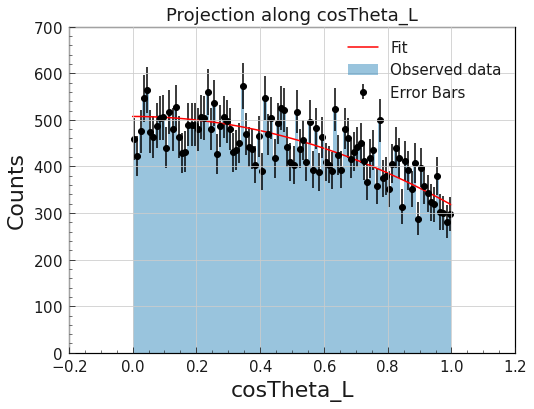

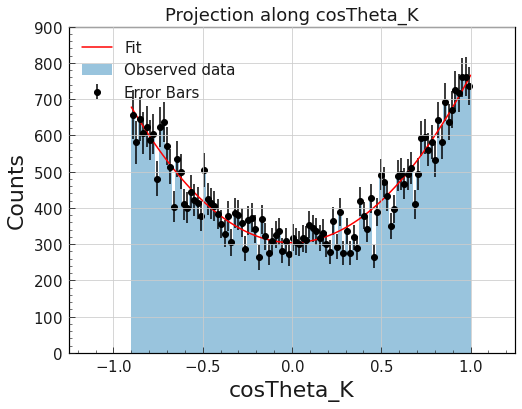

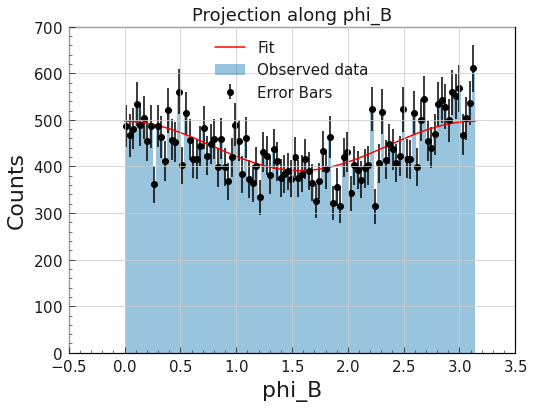

Integral of PDF along cosTheta_K: 44680.03129450706
Integral of PDF along cosTheta_L: 44367.34231974214
Integral of PDF along phi_B: 44452.27348053941


Sum of data along cosTheta_K: 43936.0395642324
Sum of data along cosTheta_L: 43936.0395642324
Sum of data along phi_B: 43936.0395642324
Total number of events: 43955.28322893845


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import simps

# Define the ranges for each variable
cosTheta_K_range = np.linspace(-0.9, 1.0, 100)
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

# Create a meshgrid of points
cosTheta_K_grid, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range, cosTheta_L_range, phi_B_range)

# Flatten the grids to evaluate the PDF
points = np.vstack([cosTheta_K_grid.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

# Evaluate the fitted PDF at each point
pdf_values_gr = pdf_fit_signal_gr.pdf(points).numpy().reshape(cosTheta_K_grid.shape)

# Integration step
# Integrate the PDF over cosTheta_L and phi_B for each cosTheta_K
integrated_pdf_values_K = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1)

# Normalize the integrated PDF
pdf_values_K = integrated_pdf_values_K * sum(mc_mu_only_signal_weight_fold) * np.diff(cosTheta_K_range)[0]

# Plot the results
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_only_signal_fold["cosTheta_L"], bins=100, weights=mc_mu_only_signal_weight_fold, density=False, alpha=0.5, label='Observed data')
bin_centers = (bins[:-1] + bins[1:]) / 2
# Calculate errors
bin_weights = [mc_mu_only_signal_weight_fold.iloc[np.where((mc_mu_only_signal_fold["cosTheta_L"] >= bins[i]) & (mc_mu_only_signal_fold["cosTheta_L"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
plt.plot(cosTheta_L_range, pdf_values_K, 'r', label='Fit')
plt.xlabel('cosTheta_L')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_L')
plt.grid(True)

# Repeat similar steps for cosTheta_L and phi_B
# For cosTheta_L
integrated_pdf_values_L = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_K_range, axis=0)
pdf_values_L = integrated_pdf_values_L * sum(mc_mu_only_signal_weight_fold) * np.diff(cosTheta_L_range)[0]

plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_only_signal_fold["cosTheta_K"], bins=100, weights=mc_mu_only_signal_weight_fold, density=False, alpha=0.5, label='Observed data')
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_weights = [mc_mu_only_signal_weight_fold.iloc[np.where((mc_mu_only_signal_fold["cosTheta_K"] >= bins[i]) & (mc_mu_only_signal_fold["cosTheta_K"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
plt.plot(cosTheta_K_range, pdf_values_L, 'r', label='Fit')
plt.xlabel('cosTheta_K')
plt.xlim(-1.25,1.25)
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_K')
plt.grid(True)

# For phi_B
integrated_pdf_values_B = simps(simps(pdf_values_gr, cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)
pdf_values_B = integrated_pdf_values_B * sum(mc_mu_only_signal_weight_fold) * np.diff(phi_B_range)[0]

plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_only_signal_fold["phi_B"], bins=100, weights=mc_mu_only_signal_weight_fold, density=False, alpha=0.5, label='Observed data')
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_weights = [mc_mu_only_signal_weight_fold.iloc[np.where((mc_mu_only_signal_fold["phi_B"] >= bins[i]) & (mc_mu_only_signal_fold["phi_B"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
plt.plot(phi_B_range, pdf_values_B, 'r', label='Fit')
plt.xlabel('phi_B')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along phi_B')
plt.grid(True)

plt.show()

from scipy.integrate import simps

# Update the summation axes based on the actual shape of pdf_values_gr
integral_L = sum(pdf_values_K)
integral_K = sum(pdf_values_L)
integral_B = sum(pdf_values_B)

print("Integral of PDF along cosTheta_K:", integral_K)
print("Integral of PDF along cosTheta_L:", integral_L)
print("Integral of PDF along phi_B:", integral_B)

print()
print()
total_data_sum_K = sum(mc_mu_only_signal_weight_fold)
total_data_sum_L = sum(mc_mu_only_signal_weight_fold)
total_data_sum_B = sum(mc_mu_only_signal_weight_fold)

print("Sum of data along cosTheta_K:", total_data_sum_K)
print("Sum of data along cosTheta_L:", total_data_sum_L)
print("Sum of data along phi_B:", total_data_sum_B)


# Integration step over the entire 3D space
integrated_pdf_total = simps(simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

# Find the number of events by normalizing the total integrated PDF
num_events_total = integrated_pdf_total * sum(mc_mu_only_signal_weight_fold)

print("Total number of events:", num_events_total)

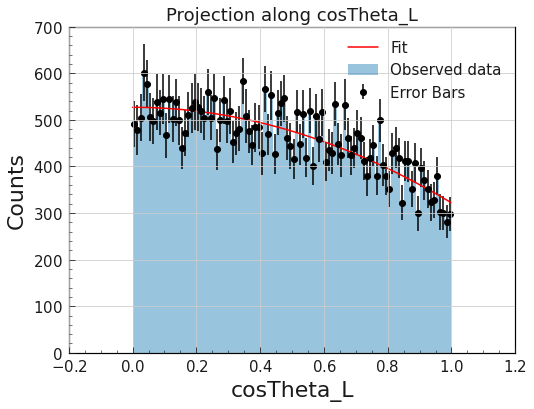

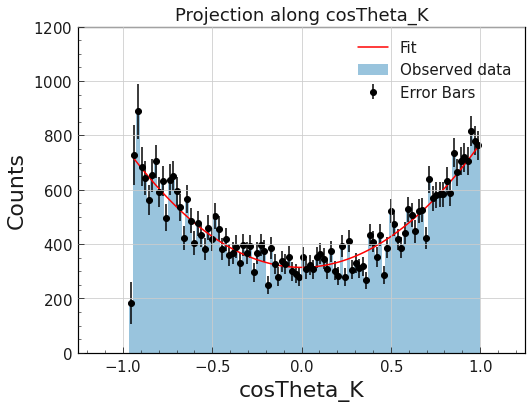

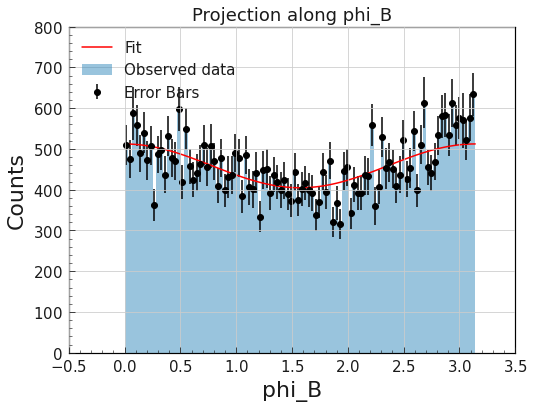

Integral of PDF along cosTheta_K: 46144.0034256926
Integral of PDF along cosTheta_L: 45818.6796820217
Integral of PDF along phi_B: 45906.936751514746
Total number of events: 45394.683078099915


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import simps

# Define the ranges for each variable
cosTheta_K_range = np.linspace(-0.95, 1.0, 100)
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

# Create a meshgrid of points
cosTheta_K_grid, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range, cosTheta_L_range, phi_B_range)

# Flatten the grids to evaluate the PDF
points = np.vstack([cosTheta_K_grid.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

# Evaluate the fitted PDF at each point
pdf_values_gr = pdf_fit_signal_kl.pdf(points).numpy().reshape(cosTheta_K_grid.shape)

# Integration step
# Integrate the PDF over cosTheta_L and phi_B for each cosTheta_K
integrated_pdf_values_K = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1)

# Normalize the integrated PDF
pdf_values_K = integrated_pdf_values_K * sum(mc_mu_only_signal_weight_wo_klcut_fold) * np.diff(cosTheta_K_range)[0]

# Plot the results
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_only_signal_wo_klcut_fold["cosTheta_L"], bins=100, weights=mc_mu_only_signal_weight_wo_klcut_fold, density=False, alpha=0.5, label='Observed data')
bin_centers = (bins[:-1] + bins[1:]) / 2
# Calculate errors
bin_weights = [mc_mu_only_signal_weight_wo_klcut_fold.iloc[np.where((mc_mu_only_signal_wo_klcut_fold["cosTheta_L"] >= bins[i]) & (mc_mu_only_signal_wo_klcut_fold["cosTheta_L"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
plt.plot(cosTheta_L_range, pdf_values_K, 'r', label='Fit')
plt.xlabel('cosTheta_L')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_L')
plt.grid(True)

# Repeat similar steps for cosTheta_L and phi_B
# For cosTheta_L
integrated_pdf_values_L = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_K_range, axis=0)
pdf_values_L = integrated_pdf_values_L * sum(mc_mu_only_signal_weight_wo_klcut_fold) * np.diff(cosTheta_L_range)[0]

plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_only_signal_wo_klcut_fold["cosTheta_K"], bins=100, weights=mc_mu_only_signal_weight_wo_klcut_fold, density=False, alpha=0.5, label='Observed data')
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_weights = [mc_mu_only_signal_weight_wo_klcut_fold.iloc[np.where((mc_mu_only_signal_wo_klcut_fold["cosTheta_K"] >= bins[i]) & (mc_mu_only_signal_wo_klcut_fold["cosTheta_K"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
plt.plot(cosTheta_K_range, pdf_values_L, 'r', label='Fit')
plt.xlabel('cosTheta_K')
plt.xlim(-1.25,1.25)
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_K')
plt.grid(True)

# For phi_B
integrated_pdf_values_B = simps(simps(pdf_values_gr, cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)
pdf_values_B = integrated_pdf_values_B * sum(mc_mu_only_signal_weight_wo_klcut_fold) * np.diff(phi_B_range)[0]

plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_only_signal_wo_klcut_fold["phi_B"], bins=100, weights=mc_mu_only_signal_weight_wo_klcut_fold, density=False, alpha=0.5, label='Observed data')
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_weights = [mc_mu_only_signal_weight_wo_klcut_fold.iloc[np.where((mc_mu_only_signal_wo_klcut_fold["phi_B"] >= bins[i]) & (mc_mu_only_signal_wo_klcut_fold["phi_B"] < bins[i+1]))[0]].tolist() for i in range(len(bins) - 1)]
errors = [np.sqrt(sum(np.square(w))) for w in bin_weights]
plt.errorbar(bin_centers, n, yerr=errors, fmt='o', color='black', label='Error Bars')
plt.plot(phi_B_range, pdf_values_B, 'r', label='Fit')
plt.xlabel('phi_B')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along phi_B')
plt.grid(True)

plt.show()


from scipy.integrate import simps

# Update the summation axes based on the actual shape of pdf_values_gr
integral_L = sum(pdf_values_K)
integral_K = sum(pdf_values_L)
integral_B = sum(pdf_values_B)

print("Integral of PDF along cosTheta_K:", integral_K)
print("Integral of PDF along cosTheta_L:", integral_L)
print("Integral of PDF along phi_B:", integral_B)


# Integration step over the entire 3D space
integrated_pdf_total = simps(simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)

# Find the number of events by normalizing the total integrated PDF
num_events_total = integrated_pdf_total * sum(mc_mu_only_signal_weight_wo_klcut_fold)

print("Total number of events:", num_events_total)

## Braching ratio ##

In [ ]:
import uncertainties as unc

cross_section_nb = 0.5346e-9  # Cross-section in nanobarns
luminosity_nb = 368.4e+15  # Luminosity in femtobarns


N_bb_mesons=cross_section_nb * (4*luminosity_nb)

print(N_bb_mesons)

In [ ]:
N_signal_yield = unc.ufloat(69202.035, 280)
B_JPsi_to_ll = unc.ufloat(5.961, 0.033) / 100  
B_K_to_K_pi = unc.ufloat(99.902, 0.009) / 100  

BR_MC = N_signal_yield / ((2 * N_bb_mesons)*B_JPsi_to_ll*B_K_to_K_pi)

BR_PDG=unc.ufloat(1.270e-3, 0.05e-3)

print("B _to_JPsi_and_K*_for_muon_Branching_ratio_from_fit_without_weight:",BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:",BR_PDG)


In [ ]:
(55221.238 +/- 250)+12381.5

67602.738 +/- 250

In [ ]:

from uncertainties import ufloat
N_signal_yield = ufloat(67602.738, 250)
B_JPsi_to_ll = ufloat(5.971, 0.032) / 100  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = N_signal_yield / ((2 * N_bb_mesons)*B_JPsi_to_ll*B_K_to_K_pi)

BR_PDG = ufloat(1.270e-3, 0.05e-3)

print("B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight:", BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:", BR_PDG)


In [ ]:
from uncertainties import ufloat
N_signal_yield = 66423.661
B_JPsi_to_ll = ufloat(5.971, 0.032) / 100  
B_K_to_K_pi = (ufloat(99.754, 0.021) / 100) * 2 / 3  # Divide by 100 and then multiply by 2/3

BR_MC = N_signal_yield / ((2 * N_bb_mesons)*B_JPsi_to_ll*B_K_to_K_pi)

BR_PDG = ufloat(1.270e-3, 0.05e-3)

print("B _to_JPsi_and_K*_for_electron_Branching_ratio_from_fit_without_weight:", BR_MC)
print("B _to_JPsi_and_K*_Branching_ratio_from_PDG:", BR_PDG)
